In [22]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [23]:
#import data

seer_data = spark.read.csv('./SEER 2018-2022.txt', header = False, sep = '\t')

#### Acquire and Add Column Names to Dataframe

In [24]:
#text-processing for column names

dictionary_text = '''
Var1Name=Year of diagnosis
Var1DisplayType=Formatted
Var2Name=Age recode with <1 year olds and 90+
Var2DisplayType=Formatted
Var3Name=Sex
Var3DisplayType=Formatted
Var4Name=Race recode (W, B, AI, API)
Var4DisplayType=Formatted
Var5Name=Origin recode NHIA (Hispanic, Non-Hisp)
Var5DisplayType=Formatted
Var6Name=Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)
Var6DisplayType=Formatted
Var7Name=Median household income inflation adj to 2023
Var7DisplayType=Formatted
Var8Name=Rural-Urban Continuum Code
Var8DisplayType=Formatted
Var9Name=Sequence number
Var9DisplayType=Formatted
Var10Name=First malignant primary indicator
Var10DisplayType=Formatted
Var11Name=Primary by international rules
Var11DisplayType=Formatted
Var12Name=Record number recode
Var12DisplayType=Formatted
Var13Name=Total number of in situ/malignant tumors for patient
Var13DisplayType=Formatted
Var14Name=Total number of benign/borderline tumors for patient
Var14DisplayType=Formatted
Var15Name=AYA site recode 2020 Revision
Var15DisplayType=Formatted
Var16Name=SEER Brain and CNS Recode
Var16DisplayType=Formatted
Var17Name=Behavior code ICD-O-3
Var17DisplayType=Formatted
Var18Name=Primary Site - labeled
Var18DisplayType=Formatted
Var19Name=Primary Site
Var19DisplayType=Formatted
Var20Name=Histologic Type ICD-O-3
Var20DisplayType=Formatted
Var21Name=Combined Summary Stage with Expanded Regional Codes (2004+)
Var21DisplayType=Formatted
Var22Name=Derived EOD 2018 T Recode (2018+)
Var22DisplayType=Formatted
Var23Name=Derived EOD 2018 N Recode (2018+)
Var23DisplayType=Formatted
Var24Name=Derived EOD 2018 M Recode (2018+)
Var24DisplayType=Formatted
Var25Name=Derived EOD 2018 Stage Group Recode (2018+)
Var25DisplayType=Formatted
Var26Name=Derived AJCC Stage Group, 7th ed (2010-2015)
Var26DisplayType=Formatted
Var27Name=Derived AJCC T, 7th ed (2010-2015)
Var27DisplayType=Formatted
Var28Name=Derived AJCC N, 7th ed (2010-2015)
Var28DisplayType=Formatted
Var29Name=Derived AJCC M, 7th ed (2010-2015)
Var29DisplayType=Formatted
Var30Name=7th Edition Stage Group Recode (2016-2017)
Var30DisplayType=Formatted
Var31Name=Derived SEER Cmb Stg Grp (2016-2017)
Var31DisplayType=Formatted
Var32Name=Derived SEER Combined T (2016-2017)
Var32DisplayType=Formatted
Var33Name=Derived SEER Combined N (2016-2017)
Var33DisplayType=Formatted
Var34Name=Derived SEER Combined M (2016-2017)
Var34DisplayType=Formatted
Var35Name=Derived SEER Combined T Src (2016-2017)
Var35DisplayType=Formatted
Var36Name=Derived SEER Combined N Src (2016-2017)
Var36DisplayType=Formatted
Var37Name=Derived SEER Combined M Src (2016-2017)
Var37DisplayType=Formatted
Var38Name=TNM Edition Number (2016-2017)
Var38DisplayType=Formatted
Var39Name=RX Summ--Surg Prim Site (1998+)
Var39DisplayType=Formatted
Var40Name=RX Summ--Scope Reg LN Sur (2003+)
Var40DisplayType=Formatted
Var41Name=RX Summ--Surg Oth Reg/Dis (2003+)
Var41DisplayType=Formatted
Var42Name=RX Summ--Surg/Rad Seq
Var42DisplayType=Formatted
Var43Name=Reason no cancer-directed surgery
Var43DisplayType=Formatted
Var44Name=Radiation recode
Var44DisplayType=Formatted
Var45Name=Chemotherapy recode (yes, no/unk)
Var45DisplayType=Formatted
Var46Name=Scope of reg lymph nd surg (1998-2002)
Var46DisplayType=Formatted
Var47Name=RX Summ--Reg LN Examined (1998-2002)
Var47DisplayType=Formatted
Var48Name=Surgery of oth reg/dis sites (1998-2002)
Var48DisplayType=Formatted
Var49Name=Site specific surgery (1973-1997 varying detail by year and site)
Var49DisplayType=Formatted
Var50Name=Radiation to Brain or CNS Recode (1988-1997)
Var50DisplayType=Formatted
Var51Name=RX Summ--Systemic/Sur Seq (2007+)
Var51DisplayType=Formatted
Var52Name=Time from diagnosis to treatment in days recode
Var52DisplayType=Formatted
Var53Name=COD to site recode
Var53DisplayType=Formatted
Var54Name=SEER cause-specific death classification
Var54DisplayType=Formatted
Var55Name=SEER other cause of death classification
Var55DisplayType=Formatted
Var56Name=Survival months
Var56DisplayType=Formatted
Var57Name=Survival months flag
Var57DisplayType=Formatted
Var58Name=COD to site rec KM
Var58DisplayType=Formatted
Var59Name=COD to site recode ICD-O-3 2023 Revision
Var59DisplayType=Formatted
Var60Name=COD to site recode ICD-O-3 2023 Revision Expanded (1999+)
Var60DisplayType=Formatted
Var61Name=Vital status recode (study cutoff used)
Var61DisplayType=Formatted
'''

#split text into lines
lines = dictionary_text.strip().splitlines()

#Filter out lines containing 'Formatted'
name_lines = [line for line in lines if 'Formatted' not in line]

#clean up name lines by removing the 'VARxxDisplayType=' section of each line
col_names = [line.split('=', 1)[1] for line in name_lines]

In [25]:
#add column names to dataframe
seer_data = seer_data.toDF(*col_names)

#### Remove Missing Data

In [26]:
#remove missing data and CNS cancers
seer_data_cleaned = seer_data.filter(
    (seer_data['Median household income inflation adj to 2023'] != 'Unknown/missing/no match/Not 1990-2023') & 
    (seer_data['Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)'] != 'Non-Hispanic Unknown Race') &
    (seer_data['Rural-Urban Continuum Code'] != 'Unknown/missing/no match (Alaska or Hawaii - Entire State)') &
    (seer_data['Rural-Urban Continuum Code'] != 'Unknown/missing/no match/Not 1990-2023') &
    (seer_data['Time from diagnosis to treatment in days recode'] != 'Unable to calculate') &
    (seer_data['Time from diagnosis to treatment in days recode'] != '731+ days') &
    (seer_data['SEER Brain and CNS Recode'] == '5. All Other Cancer Types')
    )


In [27]:
import pyspark.pandas as ps
from scipy import stats

In [28]:
#take a sample of the dataset for analysis and convert to pandas dataframe
sample_df = seer_data_cleaned.sample(fraction=0.02, seed=42)
sample_pd = sample_df.toPandas()

In [29]:
#convert 'Time from diagnosis to treatment in days recode' column to integer
sample_pd['Time from diagnosis to treatment in days recode'] = sample_pd['Time from diagnosis to treatment in days recode'].astype(int)

## Machine Learning Models

In [30]:
#add binary classification column to dataset; 0 for <28 days and 1 for >=28days for 'time from diagnosis to treatment in days recode' column
sample_pd['Treatment Delay'] = sample_pd['Time from diagnosis to treatment in days recode'].apply(lambda x: 0 if x < 28 else 1)

In [31]:
#convert year, survival months, totla number of malignant and total number of benign tumors to integer
sample_pd['Year of diagnosis'] = sample_pd['Year of diagnosis'].astype(int)
sample_pd['Survival months'] = sample_pd['Survival months'].astype(int)
sample_pd['Total number of in situ/malignant tumors for patient'] = sample_pd['Total number of in situ/malignant tumors for patient'].astype(int)
sample_pd['Total number of benign/borderline tumors for patient'] = sample_pd['Total number of benign/borderline tumors for patient'].astype(int)

#### Model Building without Feature Engineering

In [32]:
#split data into testing/training sets
from sklearn.model_selection import train_test_split

model_data = sample_pd.drop(columns=['Treatment Delay', 'Time from diagnosis to treatment in days recode', 'Survival months'])

target_feature = sample_pd['Treatment Delay']

x_train, x_test, y_train, y_test = train_test_split(model_data, target_feature, test_size = 0.2, random_state = 42)

In [33]:
#encode columns: ordinal features (income, population, age) and nominal features (all other columns except year of diagnosis, survival months, time to treatment)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone

ordinal_features = ['Age recode with <1 year olds and 90+', 'Median household income inflation adj to 2023', 'Rural-Urban Continuum Code']
numeric_features = ['Year of diagnosis', 'Total number of in situ/malignant tumors for patient', 'Total number of benign/borderline tumors for patient']

all_features = x_train.columns.tolist()
nominal_features = [col for col in all_features if col not in ordinal_features + numeric_features]

ordinal_transformer = OrdinalEncoder()

nominal_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('ord', ordinal_transformer, ordinal_features),
    ('nom', nominal_transformer, nominal_features),
    ('num', 'passthrough', numeric_features)
])


In [34]:

#build models without feature engineering

#random forest
rf_model = Pipeline(steps=[
    ('preprocessor',clone(preprocessor)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state = 42))
])

#gradient boosting classifier
gb_model = Pipeline(steps=[
    ('preprocessor', clone(preprocessor)),
    ('classifier', GradientBoostingClassifier())
])

#train models
rf_model.fit(x_train, y_train)
gb_model.fit(x_train, y_train)

#test models
rf_pred = rf_model.predict(x_test)
gb_pred = gb_model.predict(x_test)

In [35]:
#evaluate models
from sklearn.metrics import classification_report

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))

print("\nGradient Boosting Results:")
print(classification_report(y_test, gb_pred))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      3355
           1       0.71      0.72      0.72      3508

    accuracy                           0.71      6863
   macro avg       0.71      0.71      0.71      6863
weighted avg       0.71      0.71      0.71      6863


Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      3355
           1       0.71      0.75      0.73      3508

    accuracy                           0.72      6863
   macro avg       0.72      0.71      0.72      6863
weighted avg       0.72      0.72      0.72      6863



#### Model Building with Feature Engineering - Select K Best

In [36]:
#feature engineering with Select K Best
from sklearn.feature_selection import SelectKBest, chi2

#random forest
rf_model_k30 = Pipeline(steps=[
    ('preprocessor',clone(preprocessor)),
    ('feature_selection', SelectKBest(score_func=chi2, k=30)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state = 42))
])

#gradient boosting classifier
gb_model_k30 = Pipeline(steps=[
    ('preprocessor', clone(preprocessor)),
    ('feature_selection', SelectKBest(score_func=chi2, k=30)),
    ('classifier', GradientBoostingClassifier())
])

#train models
rf_model_k30.fit(x_train, y_train)
gb_model_k30.fit(x_train, y_train)

#test models
rf_pred_k30 = rf_model_k30.predict(x_test)
gb_pred_k30 = gb_model_k30.predict(x_test)

print("Random Forest with Select K Best Results:")
print(classification_report(y_test, rf_pred_k30))

print("\nGradient Boosting with Select K Best Results:")
print(classification_report(y_test, gb_pred_k30))

Random Forest with Select K Best Results:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      3355
           1       0.67      0.74      0.70      3508

    accuracy                           0.68      6863
   macro avg       0.68      0.68      0.67      6863
weighted avg       0.68      0.68      0.68      6863


Gradient Boosting with Select K Best Results:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3355
           1       0.67      0.73      0.70      3508

    accuracy                           0.68      6863
   macro avg       0.68      0.68      0.68      6863
weighted avg       0.68      0.68      0.68      6863



#### Model Building with Manual Feature Selection

In [37]:
#feature engineering with manually selected features
model_data_manual = sample_pd[[
    'Year of diagnosis',
    'Age recode with <1 year olds and 90+',
    'Sex',
    'Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)',
    'Median household income inflation adj to 2023',
    'Rural-Urban Continuum Code',
    'Sequence number',
    'First malignant primary indicator',
    'Primary by international rules',
    'Total number of in situ/malignant tumors for patient',
    'Total number of benign/borderline tumors for patient',
    'AYA site recode 2020 Revision',
    'Primary Site - labeled',
    'Histologic Type ICD-O-3',
    'Combined Summary Stage with Expanded Regional Codes (2004+)',
    'Derived EOD 2018 T Recode (2018+)',
    'Derived EOD 2018 N Recode (2018+)',
    'Derived EOD 2018 M Recode (2018+)',
    'Derived EOD 2018 Stage Group Recode (2018+)',
    'RX Summ--Surg/Rad Seq',
    'Reason no cancer-directed surgery',
    'Radiation recode',
    'Chemotherapy recode (yes, no/unk)',
    'RX Summ--Systemic/Sur Seq (2007+)',
]]

target_feature_manual = sample_pd['Treatment Delay']


#split to training / testing sets
x_train_manual, x_test_manual, y_train_manual, y_test_manual = train_test_split(model_data_manual, target_feature_manual, test_size = 0.2, random_state = 42)


In [38]:
#encode columns: ordinal features (income, population, age) and nominal features (all other columns except year of diagnosis, survival months, time to treatment)

ordinal_features = ['Age recode with <1 year olds and 90+', 'Median household income inflation adj to 2023', 'Rural-Urban Continuum Code']
numeric_features = ['Year of diagnosis', 'Total number of in situ/malignant tumors for patient', 'Total number of benign/borderline tumors for patient']

all_features_manual = x_train_manual.columns.tolist()
nominal_features = [col for col in all_features_manual if col not in ordinal_features + numeric_features]

ordinal_transformer = OrdinalEncoder()

nominal_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor_manual = ColumnTransformer(transformers=[
    ('ord', ordinal_transformer, ordinal_features),
    ('nom', nominal_transformer, nominal_features),
    ('num', 'passthrough', numeric_features)
])

In [39]:
#build models on manually selected features
#random forest
rf_model_manual = Pipeline(steps=[
    ('preprocessor',clone(preprocessor_manual)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state = 42))
])

#gradient boosting classifier
gb_model_manual = Pipeline(steps=[
    ('preprocessor', clone(preprocessor_manual)),
    ('classifier', GradientBoostingClassifier())
])

#train models
rf_model_manual.fit(x_train_manual, y_train_manual)
gb_model_manual.fit(x_train_manual, y_train_manual)

#test models
rf_pred_manual = rf_model_manual.predict(x_test_manual)
gb_pred_manual = gb_model_manual.predict(x_test_manual)

#evaluate models

print("Random Forest with Manual Feature Selection Results:")
print(classification_report(y_test_manual, rf_pred_manual))

print("\nGradient Boosting with Manual Feature Selection Results:")
print(classification_report(y_test_manual, gb_pred_manual))

Random Forest with Manual Feature Selection Results:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      3355
           1       0.71      0.72      0.71      3508

    accuracy                           0.71      6863
   macro avg       0.71      0.71      0.71      6863
weighted avg       0.71      0.71      0.71      6863


Gradient Boosting with Manual Feature Selection Results:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      3355
           1       0.71      0.71      0.71      3508

    accuracy                           0.70      6863
   macro avg       0.70      0.70      0.70      6863
weighted avg       0.70      0.70      0.70      6863



## Important Feature Identification and Model Interpretation with SHAP Values

### For Model Without Feature Engineering

In [40]:
#important feature extraction for random forest model
import pandas as pd

rf_clf = rf_model.named_steps['classifier']
rf_preprocessor = rf_model.named_steps['preprocessor']

#extract feature names
feature_names = rf_preprocessor.get_feature_names_out()

#extract importances
importances = rf_clf.feature_importances_

#combine feature names / importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending = False)

pd.set_option('display.max_colwidth', None)

feature_importances_df.head(20)

,Feature,importance
0,ord__Age recode with <1 year olds and 90+,0.059058
1,ord__Median household income inflation adj to 2023,0.056906
1754,num__Year of diagnosis,0.044309
2,ord__Rural-Urban Continuum Code,0.030858
1347,nom__Radiation recode_None/Unknown,0.012227
1755,num__Total number of in situ/malignant tumors for patient,0.009838
1365,nom__RX Summ--Systemic/Sur Seq (2007+)_Systemic therapy after surgery,0.009785
1345,nom__Radiation recode_Beam radiation,0.009470
4,nom__Sex_Male,0.009090
1316,nom__RX Summ--Scope Reg LN Sur (2003+)_None,0.008942


In [41]:
#create dictionary to rename features in more readable format:

feature_dict = {
    'ord__Age recode with <1 year olds and 90+': 'Age Group',
    'ord__Median household income inflation adj to 2023': 'Median Household Income',
    'num__Year of diagnosis': 'Year of Diagnosis',
    'ord__Rural-Urban Continuum Code': 'Metropolitan Area',
    'nom__Radiation recode_None/Unknown': 'Radiation: None/Unknown',
    'num__Total number of in situ/malignant tumors for patient': 'Total Tumors',
    'nom__RX Summ--Systemic/Sur Seq (2007+)_Systemic therapy after surgery': 'Systemic Therapy Given',
    'nom__Radiation recode_Beam radiation': 'Radiation: Beam',
    'nom__Sex_Male': 'Sex: Male',
    'nom__RX Summ--Scope Reg LN Sur (2003+)_None':'Scope of Regional Lymph Node Surgery: Not Done',
    'nom__Sex_Female': 'Sex: Female',
    'nom__Derived EOD 2018 T Recode (2018+)_T1c': 'Tumor Stage: T1c',
    'nom__RX Summ--Systemic/Sur Seq (2007+)_No systemic therapy and/or surgical procedures': 'Systemic Therapy / Surgery: Not Done',
    'nom__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic White	': 'Race/Ethnicity: Non-Hispanic White',
    'nom__Reason no cancer-directed surgery_Surgery performed': 'Reason Surgery Not Done',
    'nom__RX Summ--Surg Prim Site (1998+)_00': 'Primary Surgery Site',
    'nom__Derived EOD 2018 T Recode (2018+)_T2': 'Tumor Stage: T2',
    'nom__RX Summ--Surg Prim Site (1998+)_50': 'Primary Site Surgery: Code 50',
    'nom__AYA site recode 2020 Revision_9.7.5 Carcinoma of prostate': 'Prostate Carcinoma',
    'nom__Primary Site - labeled_C61.9-Prostate gland': 'Primary Site: Prostate'
}

#
top_20_features = feature_importances_df.head(20)

top_20_features['Feature_renamed'] = top_20_features['Feature'].map(feature_dict)

/var/folders/db/00b5nl595fldz7p9j42cw4q80000gn/T/ipykernel_49931/3049279882.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_features['Feature_renamed'] = top_20_features['Feature'].map(feature_dict)


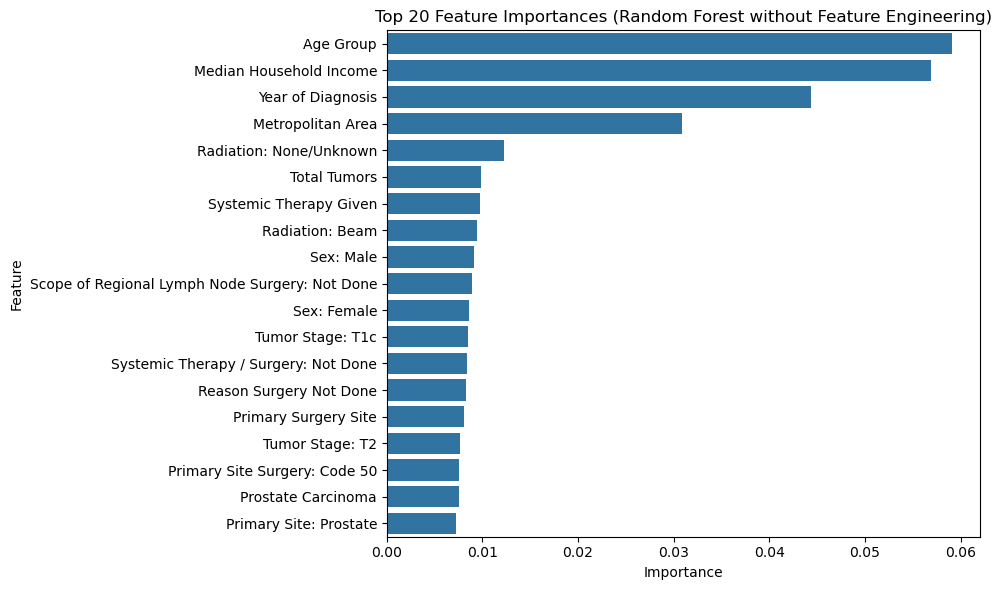

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x = 'importance', y='Feature_renamed', data = top_20_features)
plt.title('Top 20 Feature Importances (Random Forest without Feature Engineering)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()